[*********************100%***********************]  1 of 1 completed


Data shape: (3269, 5)
Date range: 2011-01-04 00:00:00 to 2023-12-29 00:00:00

Starting walk-forward test (OHLC only)...

--- Period 1 ---
Train: 2011-01-04 to 2011-07-05
Test: 2011-07-06 to 2011-08-03
Training agent...
Episode 0/50, Reward: 0.0366, Epsilon: 0.995
Episode 10/50, Reward: -0.0116, Epsilon: 0.946
Episode 20/50, Reward: -0.0311, Epsilon: 0.900
Episode 30/50, Reward: 0.0678, Epsilon: 0.856
Episode 40/50, Reward: 0.1476, Epsilon: 0.814
Test profit: -0.0094
Number of trades: 6

--- Period 2 ---
Train: 2011-02-03 to 2011-08-03
Test: 2011-08-04 to 2011-09-01
Training agent...
Episode 0/50, Reward: -0.1027, Epsilon: 0.995
Episode 10/50, Reward: 0.1020, Epsilon: 0.946
Episode 20/50, Reward: 0.1310, Epsilon: 0.900
Episode 30/50, Reward: 0.2726, Epsilon: 0.856
Episode 40/50, Reward: 0.1071, Epsilon: 0.814
Test profit: 0.0552
Number of trades: 6

--- Period 3 ---
Train: 2011-03-07 to 2011-09-01
Test: 2011-09-02 to 2011-10-03
Training agent...
Episode 0/50, Reward: -0.1394, Epsilon: 0

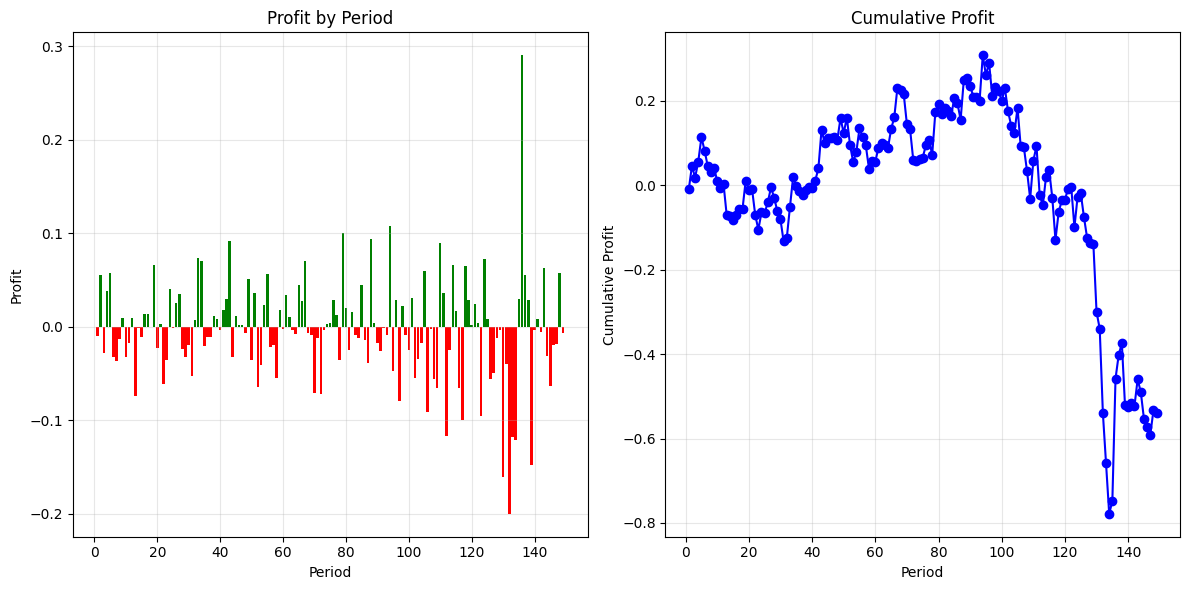


📊 Chart saved as results/ohlc_trading_results.png


In [ ]:
# -----------------------------
# Deep Q-Learning Trading Agent
# OHLC Only
# -----------------------------
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
import warnings
import os
warnings.filterwarnings('ignore')

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# -----------------------------
# Config
# -----------------------------
TICKER = "GOOG"
START_DATE = "2011-01-01"
END_DATE = "2023-12-31"
STATE_WINDOW = 10
TRAIN_MONTHS = 6
TEST_MONTHS = 1
EPISODES = 50
BATCH_SIZE = 32
LR = 0.001
GAMMA = 0.95
EPSILON_START = 1.0
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.995
MEMORY_SIZE = 10000
TARGET_UPDATE = 10

# -----------------------------
# Download Data
# -----------------------------
print("Downloading data...")
df = yf.download(TICKER, start=START_DATE, end=END_DATE)

# Keep OHLC only
df = df[['Open', 'High', 'Low', 'Close']].copy()
df.dropna(inplace=True)

# Returns for reference
df['Returns'] = df['Close'].pct_change()
df.dropna(inplace=True)

print(f"Data shape: {df.shape}")
print(f"Date range: {df.index[0]} to {df.index[-1]}")

# -----------------------------
# Trading Environment
# -----------------------------
class TradingEnv:
    def __init__(self, data, window=STATE_WINDOW, initial_balance=10000):
        self.data = data
        self.window = window
        self.initial_balance = initial_balance
        self.reset()

    def reset(self):
        self.current_step = self.window
        self.position = 0
        self.entry_price = 0.0
        self.total_profit = 0.0
        self.trades = []
        return self._get_state()

    def _get_state(self):
        if self.current_step >= len(self.data):
            return np.zeros(self.window * 4 + 1)
        features = self.data[['Open', 'High', 'Low', 'Close']] \
            .iloc[self.current_step - self.window:self.current_step].values
        norm = (features - np.mean(features, axis=0)) / (np.std(features, axis=0) + 1e-8)
        state = norm.flatten()
        state = np.append(state, self.position)
        return state

    def step(self, action):
        if self.current_step >= len(self.data):
            return self._get_state(), 0.0, True
        reward = 0.0
        current_price = float(self.data.iloc[self.current_step]['Close'])
        transaction_cost = 0.001

        if action == 1:  # Buy
            if self.position == 0:
                self.position = 1
                self.entry_price = current_price
                reward = -transaction_cost
            elif self.position == -1:
                profit = (self.entry_price - current_price) / self.entry_price
                reward = profit - transaction_cost
                self.total_profit += reward
                self.trades.append(('close_short', profit))
                self.position = 1
                self.entry_price = current_price
        elif action == 2:  # Sell
            if self.position == 0:
                self.position = -1
                self.entry_price = current_price
                reward = -transaction_cost
            elif self.position == 1:
                profit = (current_price - self.entry_price) / self.entry_price
                reward = profit - transaction_cost
                self.total_profit += reward
                self.trades.append(('close_long', profit))
                self.position = -1
                self.entry_price = current_price
        elif action == 0:  # Hold
            if self.position == 1:
                reward = ((current_price - self.entry_price) / self.entry_price) * 0.1
            elif self.position == -1:
                reward = ((self.entry_price - current_price) / self.entry_price) * 0.1
        self.current_step += 1
        done = self.current_step >= len(self.data)
        if done and self.position != 0:
            if self.position == 1:
                final_profit = (current_price - self.entry_price) / self.entry_price
                self.total_profit += final_profit
                self.trades.append(('final_close_long', final_profit))
            else:
                final_profit = (self.entry_price - current_price) / self.entry_price
                self.total_profit += final_profit
                self.trades.append(('final_close_short', final_profit))
        return self._get_state(), float(reward), done

# -----------------------------
# DQN Model
# -----------------------------
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_dim)
        self.dropout = nn.Dropout(0.1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

# -----------------------------
# Replay Buffer
# -----------------------------
class ReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

# -----------------------------
# Training
# -----------------------------
def train_agent(train_data):
    env = TradingEnv(train_data)
    state_dim = STATE_WINDOW * 4 + 1
    action_dim = 3
    policy_net = DQN(state_dim, action_dim)
    target_net = DQN(state_dim, action_dim)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=LR)
    memory = ReplayBuffer(MEMORY_SIZE)
    epsilon = EPSILON_START
    episode_rewards = []
    print("Training agent...")
    for ep in range(EPISODES):
        state = env.reset()
        episode_reward = 0
        done = False
        while not done:
            if random.random() < epsilon:
                action = random.randrange(action_dim)
            else:
                with torch.no_grad():
                    action = torch.argmax(policy_net(torch.tensor(state, dtype=torch.float32))).item()
            next_state, reward, done = env.step(action)
            memory.push(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward
            if len(memory) >= BATCH_SIZE:
                batch = memory.sample(BATCH_SIZE)
                states, actions, rewards, next_states, dones = zip(*batch)
                states = torch.tensor(np.array(states), dtype=torch.float32)
                actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
                rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
                next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
                dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)
                q_values = policy_net(states).gather(1, actions)
                next_q_values = target_net(next_states).max(1)[0].unsqueeze(1)
                target = rewards + (GAMMA * next_q_values * (1 - dones))
                loss = nn.MSELoss()(q_values, target)
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
                optimizer.step()
        episode_rewards.append(episode_reward)
        epsilon = max(EPSILON_MIN, epsilon * EPSILON_DECAY)
        if ep % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
        if ep % 10 == 0:
            print(f"Episode {ep}/{EPISODES}, Reward: {episode_reward:.4f}, Epsilon: {epsilon:.3f}")
    return policy_net, episode_rewards

def test_agent(test_data, trained_model):
    env = TradingEnv(test_data)
    state = env.reset()
    done = False
    while not done:
        with torch.no_grad():
            action = torch.argmax(trained_model(torch.tensor(state, dtype=torch.float32))).item()
        next_state, reward, done = env.step(action)
        state = next_state
    return float(env.total_profit), len(env.trades)

# -----------------------------
# Walk-Forward Testing
# -----------------------------
def run_walk_forward_test():
    results = []
    start_idx = 0
    period = 0
    days_per_month = 21
    train_days = TRAIN_MONTHS * days_per_month
    test_days = TEST_MONTHS * days_per_month
    print(f"\nStarting walk-forward test (OHLC only)...")
    while True:
        train_end_idx = start_idx + train_days
        test_end_idx = train_end_idx + test_days
        if test_end_idx >= len(df):
            break
        period += 1
        train_data = df.iloc[start_idx:train_end_idx].copy()
        test_data = df.iloc[train_end_idx:test_end_idx].copy()
        print(f"\n--- Period {period} ---")
        print(f"Train: {train_data.index[0].strftime('%Y-%m-%d')} to {train_data.index[-1].strftime('%Y-%m-%d')}")
        print(f"Test: {test_data.index[0].strftime('%Y-%m-%d')} to {test_data.index[-1].strftime('%Y-%m-%d')}")
        model, training_rewards = train_agent(train_data)
        profit, num_trades = test_agent(test_data, model)
        results.append({
            'period': period,
            'profit': profit,
            'num_trades': num_trades,
            'train_start': train_data.index[0],
            'train_end': train_data.index[-1],
            'test_start': test_data.index[0],
            'test_end': test_data.index[-1]
        })
        print(f"Test profit: {profit:.4f}")
        print(f"Number of trades: {num_trades}")
        start_idx += test_days
    return results

# -----------------------------
# Save Results
# -----------------------------
def save_results_to_csv(results, filename="results_ohlc.csv"):
    df_results = pd.DataFrame(results)
    profits = [r['profit'] for r in results]
    summary = {
        "total_periods": len(results),
        "total_profit": sum(profits),
        "avg_profit": np.mean(profits),
        "win_rate": len([p for p in profits if p > 0]) / len(profits) * 100,
        "best_period": max(profits),
        "worst_period": min(profits)
    }
    os.makedirs("results", exist_ok=True)
    df_results.to_csv(os.path.join("results", filename.replace(".csv", "_detailed.csv")), index=False)
    pd.DataFrame([summary]).to_csv(os.path.join("results", filename.replace(".csv", "_summary.csv")), index=False)
    print(f"\n✅ Results saved to results/{filename.replace('.csv','_detailed.csv')} and results/{filename.replace('.csv','_summary.csv')}")

# -----------------------------
# Main
# -----------------------------
if __name__ == "__main__":
    results = run_walk_forward_test()
    print("\n" + "="*60)
    print("WALK-FORWARD TEST RESULTS (OHLC ONLY)")
    print("="*60)
    total_profit = sum(r['profit'] for r in results)
    profits = [r['profit'] for r in results]
    for r in results:
        print(f"Period {r['period']}: Profit = {r['profit']:.4f}, Trades = {r['num_trades']}")
    print(f"\nSUMMARY:")
    print(f"Total periods: {len(results)}")
    print(f"Total profit: {total_profit:.4f}")
    print(f"Average profit per period: {np.mean(profits):.4f}")
    win_rate = len([p for p in profits if p > 0]) / len(profits) * 100
    print(f"Win rate: {win_rate:.1f}%")
    print(f"Best period: {max(profits):.4f}")
    print(f"Worst period: {min(profits):.4f}")
    # Save
    save_results_to_csv(results, "results_ohlc.csv")
    # Plot
    periods = [r['period'] for r in results]
    cumulative_profit = np.cumsum(profits)
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.bar(periods, profits, color=['green' if p>0 else 'red' for p in profits])
    plt.title('Profit by Period')
    plt.xlabel('Period'); plt.ylabel('Profit'); plt.grid(True, alpha=0.3)
    plt.subplot(1,2,2)
    plt.plot(periods, cumulative_profit, marker='o', color='blue')
    plt.title('Cumulative Profit')
    plt.xlabel('Period'); plt.ylabel('Cumulative Profit'); plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("results/ohlc_trading_results.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n📊 Chart saved as results/ohlc_trading_results.png")
